# Introduction

This notebook will illustrate solution of the `lagaris_04` coupled ODE IVP using TensorFlow.

## The `lagaris_04` ODE problem

This system of coupled ODEs was used as the fourth example problem in (Lagaris et al., 1998). The differential equations are provided in the form (equations (30), (31) in Lagaris (1998)):

\begin{equation}
    \frac {d\psi_1} {dx} = \cos(x) + \psi_1^2 + \psi_2 - \left(1 + x^2 + \sin^2(x) \right) \\
    \frac {d\psi_2} {dx} = 2 x - \left( 1 + x^2 \right) \sin(x) + \psi_1 \psi_2
\end{equation}

or:

\begin{equation}
    G_1 \left( x, \psi_1, \psi_2, \frac {d\psi_1} {dx}, \frac {d\psi_2} {dx} \right) = \frac {d\psi_1} {dx} - \cos(x) - \psi_1^2 - \psi_2 + \left(1 + x^2 + \sin^2(x) \right) = 0 \\
    G_2 \left( x, \psi_1, \psi_2, \frac {d\psi_1} {dx}, \frac {d\psi_2} {dx} \right) = \frac {d\psi_2} {dx} - 2 x + \left( 1 + x^2 \right) \sin(x) - \psi_1 \psi_2 = 0
\end{equation}

with initial conditions:

\begin{equation}
    \psi_1(0) = 0 \\
    \psi_2(0) = 1
\end{equation}

The analytical solutions are:

\begin{equation}
    \psi_{1a}(x) = \sin (x) \\
    \psi_{2a}(x) = 1 + x^2
\end{equation}

The first derivatives are:

\begin{equation}
    \frac {d\psi_{1a}(x)} {dx} = \cos (x) \\
    \frac {d\psi_{2a}(x)} {dx} = 2 x
\end{equation}

The analytical solutions and derivatives in the domain $[0,1]$ are plotted below.

In [1]:
# Import standard Python modules.
import datetime
import importlib
import os
import platform
import sys

# Import 3rd-party modules.
import matplotlib.pyplot as plt
import numpy as np

# Import TensorFlow.
import tensorflow as tf

In [2]:
# Use 64-bit math in TensorFlow.
tf.keras.backend.set_floatx('float64')

In [3]:
# Import the problem definition.
eq_name = "lagaris_04"
eq_module = 'nnde.differentialequation.examples.lagaris_04'
eq = importlib.import_module(eq_module)

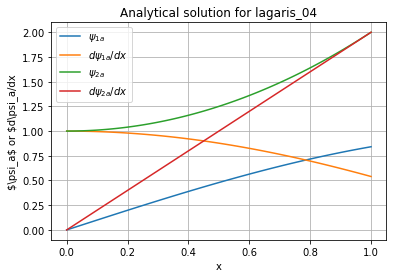

In [4]:
# Compute the analytical solution and derivatives.
# Note that Y is used in place of \psi in the code.
nxa = 101
xa = np.linspace(0, 1, nxa)
Y1a = [eq.Y1a(x) for x in xa]
Y1a = np.array(Y1a)
Y2a = [eq.Y2a(x) for x in xa]
Y2a = np.array(Y2a)
dY1a_dx = [eq.dY1a_dx(x) for x in xa]
dY1a_dx = np.array(dY1a_dx)
dY2a_dx = [eq.dY2a_dx(x) for x in xa]
dY2a_dx = np.array(dY2a_dx)

# Plot the analytical solution and derivative.
plt.plot(xa, Y1a, label="$\psi_{1a}$")
plt.plot(xa, dY1a_dx, label="$d\psi_{1a}/dx$")
plt.plot(xa, Y2a, label="$\psi_{2a}$")
plt.plot(xa, dY2a_dx, label="$d\psi_{2a}/dx$")
plt.xlabel("x")
plt.ylabel("$\psi_a$ or $d\psi_a/dx")
plt.grid()
plt.legend()
plt.title("Analytical solution for %s" % eq_name);

## Solving `lagaris_04` using TensorFlow

In [5]:
def print_system_information():
    print("System report:")
    print(datetime.datetime.now())
    print("Host name: %s" % platform.node())
    print("OS: %s" % platform.platform())
    print("uname:", platform.uname())
    print("Python version: %s" % sys.version)
    print("Python build:", platform.python_build())
    print("Python compiler: %s" % platform.python_compiler())
    print("Python implementation: %s" % platform.python_implementation())
    # print("Python file: %s" % __file__)

In [6]:
def create_output_directory(path=None):
    path_noext, ext = os.path.splitext(path)
    output_dir = path_noext
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
    return output_dir

In [7]:
from nnde.math.trainingdata import create_training_grid

def create_training_data(nt):
    x_train = np.array(create_training_grid(nt))
    return x_train

In [8]:
def build_model(H, w0_range, u0_range, v0_range):
    hidden_layer = tf.keras.layers.Dense(
        units=H, use_bias=True,
        activation=tf.keras.activations.sigmoid,
        kernel_initializer=tf.keras.initializers.RandomUniform(*w0_range),
        bias_initializer=tf.keras.initializers.RandomUniform(*u0_range)
    )
    output_layer = tf.keras.layers.Dense(
        units=1,
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(*v0_range),
        use_bias=False,
    )
    model = tf.keras.Sequential([hidden_layer, output_layer])
    return model

In [9]:
print_system_information()

System report:
2021-12-13 15:11:14.036930
Host name: C02DT5CZMD6T-ML
OS: macOS-10.16-x86_64-i386-64bit
uname: uname_result(system='Darwin', node='C02DT5CZMD6T-ML', release='20.6.0', version='Darwin Kernel Version 20.6.0: Tue Oct 12 18:33:42 PDT 2021; root:xnu-7195.141.8~1/RELEASE_X86_64', machine='x86_64', processor='i386')
Python version: 3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ]
Python build: ('default', 'Oct 12 2021 06:23:56')
Python compiler: Clang 10.0.0 
Python implementation: CPython


In [10]:
# Set up the output directory.
path = os.path.join(".", eq_name)
output_dir = create_output_directory(path)

In [11]:
# Define the hyperparameters.

# Training optimizer
optimizer_name = "Adam"

# Initial parameter ranges
w0_range = [-0.1, 0.1]
u0_range = [-0.1, 0.1]
v0_range = [-0.1, 0.1]

# Maximum number of training epochs.
max_epochs = 20000

# Learning rate.
learning_rate = 0.01

# Absolute tolerance for consecutive loss function values to indicate convergence.
tol = 1e-6

# Number of hidden nodes.
H = 10

# Number of training points.
nx_train = 11
n_train = nx_train

# Number of validation points.
nx_val = 101
n_val = nx_val

# Random number generator seed.
random_seed = 0

In [12]:
# Create and save the training data.
x_train = create_training_data(nx_train)
np.savetxt(os.path.join(output_dir, 'x_train.dat'), x_train)

# Create and save the validation data.
x_val = create_training_data(nx_val)
np.savetxt(os.path.join(output_dir, 'x_val.dat'), x_val)

In [13]:
# Define the differential equations using TensorFlow operations.

@tf.function
def difeq1(x, Y1, Y2, dY1_dx, dY2_dx):
    G = dY1_dx - tf.math.cos(x) - Y1**2 - Y2 + 1 + x**2 + tf.math.sin(x)**2
    return G

@tf.function
def difeq2(x, Y1, Y2, dY1_dx, dY2_dx):
    G = dY2_dx - 2*x + (1 + x**2)*tf.math.sin(x) - Y1*Y2
    return G

In [14]:
# Define the trial functions.

@tf.function
def Y1_trial(x, N):
    A = 0
    P = x
    Y = A + P*N
    return Y

@tf.function
def Y2_trial(x, N):
    A = 1
    P = x
    Y = A + P*N
    return Y

In [15]:
# Build the model.
model1 = build_model(H, w0_range, u0_range, v0_range)
model2 = build_model(H, w0_range, u0_range, v0_range)

# Create the optimizers.
optimizer1 = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer2 = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Create history variables.
losses1 = []
losses2 = []
losses = []
phist1 = []
phist2 = []

# Set the random number seed for reproducibility.
tf.random.set_seed(random_seed)

# Rename the training data Variable for convenience, just for training.
x_train_var = tf.Variable(x_train.reshape((n_train, 1)))
x = x_train_var

# Clear the convergence flag to start.
converged = False

# Train the model.

print("Hyperparameters: n_train = %s, H = %s, max_epochs = %s, optimizer = %s, learning_rate = %s"
      % (n_train, H, max_epochs, optimizer_name, learning_rate))
t_start = datetime.datetime.now()
print("Training started at", t_start)

for epoch in range(max_epochs):

    # Run the forward pass.
    with tf.GradientTape(persistent=True) as tape2:
        with tf.GradientTape(persistent=True) as tape1:

            # Compute the network outputs.
            N1 = model1(x)
            N2 = model2(x)

            # Compute the trial solutions.
            Y1 = Y1_trial(x, N1)
            Y2 = Y2_trial(x, N2)

        # Compute the gradients of trial solutions wrt inputs.
        dY1_dx = tape1.gradient(Y1, x)
        dY2_dx = tape1.gradient(Y2, x)

        # Compute the estimates of the differential equations.
        G1 = difeq1(x, Y1, Y2, dY1_dx, dY2_dx)
        G2 = difeq2(x, Y1, Y2, dY1_dx, dY2_dx)

        # Compute the loss functions
        L1 = tf.math.sqrt(tf.reduce_sum(G1**2)/n_train)
        L2 = tf.math.sqrt(tf.reduce_sum(G2**2)/n_train)
        L = L1 + L2
    
    # Save the current losses.
    losses1.append(L1.numpy())
    losses2.append(L2.numpy())
    losses.append(L.numpy())

    # Check for convergence.
    if epoch > 0:
        loss_delta = losses[-1] - losses[-2]
        if abs(loss_delta) <= tol:
            converged = True
            break

    # Compute the gradients of the loss function wrt the network parameters.
    pgrad1 = tape2.gradient(L, model1.trainable_variables)
    pgrad2 = tape2.gradient(L, model2.trainable_variables)

    # Save the parameters used in this pass.
    phist1.append(
        np.hstack(
            (model1.trainable_variables[0][0].numpy(),    # w (1, H) matrix
             model1.trainable_variables[1].numpy(),       # u (H,) row vector
             model1.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )
    phist2.append(
        np.hstack(
            (model2.trainable_variables[0][0].numpy(),    # w (1, H) matrix
             model2.trainable_variables[1].numpy(),       # u (H,) row vector
             model2.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
        )
    )

    # Update the parameters for this pass.
    optimizer1.apply_gradients(zip(pgrad1, model1.trainable_variables))
    optimizer2.apply_gradients(zip(pgrad2, model2.trainable_variables))

    if epoch % 100 == 0:
        print("Ending epoch %s, loss function = %s" % (epoch, L.numpy()))

# Save the parameters used in the last epoch.
phist1.append(
    np.hstack(
        (model1.trainable_variables[0][0].numpy(),    # w (1, H) matrix
         model1.trainable_variables[1].numpy(),       # u (H,) row vector
         model1.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
    )
)
phist2.append(
    np.hstack(
        (model2.trainable_variables[0][0].numpy(),    # w (1, H) matrix
         model2.trainable_variables[1].numpy(),       # u (H,) row vector
         model2.trainable_variables[2][:, 0].numpy()) # v (H, 1) column vector
    )
)

n_epochs = epoch + 1

t_stop = datetime.datetime.now()
print("Training stopped at", t_stop)
t_elapsed = t_stop - t_start
print("Total training time was %s seconds." % t_elapsed.total_seconds())
print("Epochs: %d" % n_epochs)
print("Final value of loss function: %f" % losses[-1])
print("converged = %s" % converged)

# Save the parameter histories.
np.savetxt(os.path.join(output_dir, 'phist1.dat'), np.array(phist1))
np.savetxt(os.path.join(output_dir, 'phist2.dat'), np.array(phist2))

Hyperparameters: n_train = 11, H = 10, max_epochs = 20000, optimizer = Adam, learning_rate = 0.01
Training started at 2021-12-13 15:11:14.140752


2021-12-13 15:11:14.134651: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-13 15:11:14.228211: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Ending epoch 0, loss function = 1.2850087067079987
Ending epoch 100, loss function = 0.44474884336683196
Ending epoch 200, loss function = 0.05107385307465962
Ending epoch 300, loss function = 0.04587298599860609
Ending epoch 400, loss function = 0.04147154629274656
Training stopped at 2021-12-13 15:11:20.597202
Total training time was 6.45645 seconds.
Epochs: 428
Final value of loss function: 0.039644
converged = True


In [16]:
# Compute and save the trained results at training points.
with tf.GradientTape(persistent=True) as tape:
    N1 = model1(x)
    N2 = model2(x)
    Y1t_train = Y1_trial(x, N1)
    Y2t_train = Y2_trial(x, N2)
dY1t_dx_train = tape.gradient(Y1t_train, x)
dY2t_dx_train = tape.gradient(Y2t_train, x)
np.savetxt(os.path.join(output_dir, 'Y1t_train.dat'), Y1t_train.numpy().reshape((nx_train)))
np.savetxt(os.path.join(output_dir, 'Y2t_train.dat'), Y2t_train.numpy().reshape((nx_train)))
np.savetxt(os.path.join(output_dir, 'dY1t_dx_train.dat'), dY1t_dx_train.numpy().reshape((nx_train)))
np.savetxt(os.path.join(output_dir, 'dY2t_dx_train.dat'), dY2t_dx_train.numpy().reshape((nx_train)))

# Compute and save the analytical solutions and derivatives at training points.
Y1a_train = np.array([eq.Y1a(x) for x in x_train])
Y2a_train = np.array([eq.Y2a(x) for x in x_train])
dY1a_dx_train = np.array([eq.dY1a_dx(x) for x in x_train])
dY2a_dx_train = np.array([eq.dY2a_dx(x) for x in x_train])
np.savetxt(os.path.join(output_dir,'Y1a_train.dat'), Y1a_train)
np.savetxt(os.path.join(output_dir,'Y2a_train.dat'), Y2a_train)
np.savetxt(os.path.join(output_dir,'dY1a_dx_train.dat'), dY1a_dx_train)
np.savetxt(os.path.join(output_dir,'dY2a_dx_train.dat'), dY2a_dx_train)

# Compute and save the errors in the trained solutions and derivatives at training points.
Y1t_err_train = Y1t_train.numpy().reshape((nx_train)) - Y1a_train
Y2t_err_train = Y2t_train.numpy().reshape((nx_train)) - Y2a_train
dY1t_dx_err_train = dY1t_dx_train.numpy().reshape((nx_train)) - dY1a_dx_train
dY2t_dx_err_train = dY2t_dx_train.numpy().reshape((nx_train)) - dY2a_dx_train
np.savetxt(os.path.join(output_dir, 'Y1t_err_train.dat'), Y1t_err_train)
np.savetxt(os.path.join(output_dir, 'Y2t_err_train.dat'), Y2t_err_train)
np.savetxt(os.path.join(output_dir, 'dY1t_dx_err_train.dat'), dY1t_dx_err_train)
np.savetxt(os.path.join(output_dir, 'dY2t_dx_err_train.dat'), dY2t_dx_err_train)

# Compute the final RMS errors.
Y1t_rmse_train = np.sqrt(np.sum(Y1t_err_train**2)/n_train)
print("Y1t_rmse_train = %s" % Y1t_rmse_train)
Y2t_rmse_train = np.sqrt(np.sum(Y2t_err_train**2)/n_train)
print("Y2t_rmse_train = %s" % Y2t_rmse_train)

Y1t_rmse_train = 0.008239298414249054
Y2t_rmse_train = 0.00620622686974567


In [17]:
# Compute and save the trained results at validation points.
x_val_var = tf.Variable(x_val.reshape((n_val, 1)))
x = x_val_var
with tf.GradientTape(persistent=True) as tape:
    N1 = model1(x)
    N2 = model2(x)
    Y1t_val = Y1_trial(x, N1)
    Y2t_val = Y2_trial(x, N2)
dY1t_dx_val = tape.gradient(Y1t_val, x)
dY2t_dx_val = tape.gradient(Y2t_val, x)
np.savetxt(os.path.join(output_dir, 'Y1t_val.dat'), Y1t_val.numpy().reshape((n_val)))
np.savetxt(os.path.join(output_dir, 'Y2t_val.dat'), Y2t_val.numpy().reshape((n_val)))
np.savetxt(os.path.join(output_dir, 'dY1t_dx_val.dat'), dY1t_dx_val.numpy().reshape((n_val)))
np.savetxt(os.path.join(output_dir, 'dY2t_dx_val.dat'), dY2t_dx_val.numpy().reshape((n_val)))

# Compute and save the analytical solutions and derivatives at validation points.
Y1a_val = np.array([eq.Y1a(x) for x in x_val])
Y2a_val = np.array([eq.Y2a(x) for x in x_val])
dY1a_dx_val = np.array([eq.dY1a_dx(x) for x in x_val])
dY2a_dx_val = np.array([eq.dY2a_dx(x) for x in x_val])
np.savetxt(os.path.join(output_dir,'Y1a_val.dat'), Y1a_val)
np.savetxt(os.path.join(output_dir,'Y2a_val.dat'), Y2a_val)
np.savetxt(os.path.join(output_dir,'dY1a_dx_val.dat'), dY1a_dx_val)
np.savetxt(os.path.join(output_dir,'dY2a_dx_val.dat'), dY2a_dx_val)

# Compute and save the errors in the trained solutions and derivatives at training points.
Y1t_err_val = Y1t_val.numpy().reshape((nx_val)) - Y1a_val
Y2t_err_val = Y2t_val.numpy().reshape((nx_val)) - Y2a_val
dY1t_dx_err_val = dY1t_dx_val.numpy().reshape((nx_val)) - dY1a_dx_val
dY2t_dx_err_val = dY2t_dx_val.numpy().reshape((nx_val)) - dY2a_dx_val
np.savetxt(os.path.join(output_dir, 'Y1t_err_val.dat'), Y1t_err_val)
np.savetxt(os.path.join(output_dir, 'Y2t_err_val.dat'), Y2t_err_val)
np.savetxt(os.path.join(output_dir, 'dY1t_dx_err_val.dat'), dY1t_dx_err_val)
np.savetxt(os.path.join(output_dir, 'dY2t_dx_err_val.dat'), dY2t_dx_err_val)

# Compute the final RMS errors.
Y1t_rmse_val = np.sqrt(np.sum(Y1t_err_val**2)/n_val)
print("Y1t_rmse_val = %s" % Y1t_rmse_val)
Y2t_rmse_val = np.sqrt(np.sum(Y2t_err_val**2)/n_val)
print("Y2t_rmse_val = %s" % Y2t_rmse_val)

Y1t_rmse_val = 0.007594638200036801
Y2t_rmse_val = 0.00567158896751695


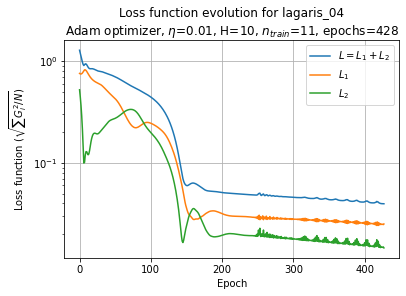

In [18]:
# Plot the loss function history.
plt.semilogy(losses, label="$L=L_1+L_2$")
plt.semilogy(losses1, label="$L_1$")
plt.semilogy(losses2, label="$L_2$")
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sqrt {\sum G_i^2/N}$)")
plt.grid()
plt.legend()
plt.title("Loss function evolution for %s\n%s optimizer, $\eta$=%s, H=%s, $n_{train}$=%s, epochs=%s" %
          (eq_name, optimizer_name, learning_rate, H, n_train, n_epochs))
plt.show()

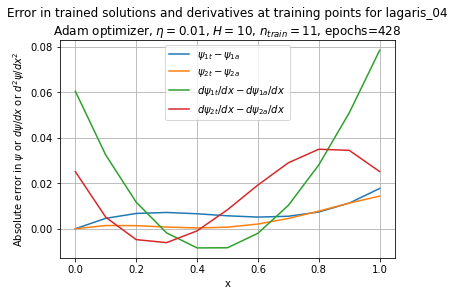

In [19]:
# Plot the errors in the trained solution and derivative at the training points.
plt.plot(x_train, Y1t_err_train, label="$\psi_{1t} - \psi_{1a}$")
plt.plot(x_train, Y2t_err_train, label="$\psi_{2t} - \psi_{2a}$")
plt.plot(x_train, dY1t_dx_err_train, label="$d\psi_{1t}/dx - d\psi_{1a}/dx$")
plt.plot(x_train, dY2t_dx_err_train, label="$d\psi_{2t}/dx - d\psi_{2a}/dx$")
plt.xlabel("x")
plt.ylabel("Absolute error in $\psi$ or $d\psi/dx$ or $d^2\psi/dx^2$")
plt.grid()
plt.legend()
plt.title("Error in trained solutions and derivatives at training points for %s\n%s optimizer, $\eta=%s$, $H=%s$, $n_{train}=%s$, epochs=$%s$" %
          (eq_name, optimizer_name, learning_rate, H, n_train, n_epochs))
plt.show()

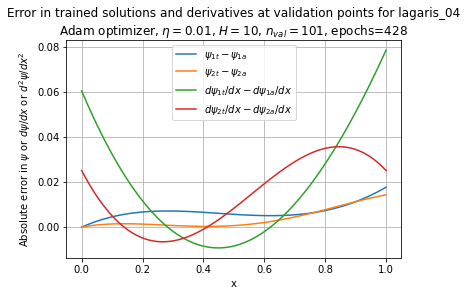

In [20]:
# Plot the errors in the trained solution and derivative at the validation points.
plt.plot(x_val, Y1t_err_val, label="$\psi_{1t} - \psi_{1a}$")
plt.plot(x_val, Y2t_err_val, label="$\psi_{2t} - \psi_{2a}$")
plt.plot(x_val, dY1t_dx_err_val, label="$d\psi_{1t}/dx - d\psi_{1a}/dx$")
plt.plot(x_val, dY2t_dx_err_val, label="$d\psi_{2t}/dx - d\psi_{2a}/dx$")
plt.xlabel("x")
plt.ylabel("Absolute error in $\psi$ or $d\psi/dx$ or $d^2\psi/dx^2$")
plt.grid()
plt.legend()
plt.title("Error in trained solutions and derivatives at validation points for %s\n%s optimizer, $\eta=%s$, $H=%s$, $n_{val}=%s$, epochs=$%s$" %
          (eq_name, optimizer_name, learning_rate, H, n_val, n_epochs))
plt.show()

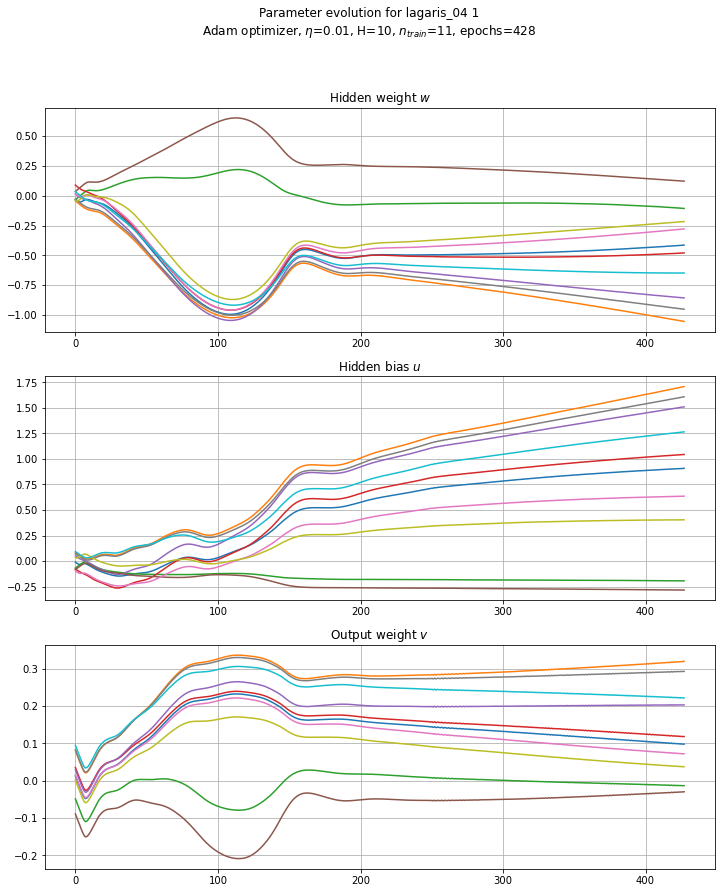

In [21]:
# Plot the parameter histories for model 1.
phist = np.array(phist1)
plt.figure(figsize=(12, 14))

# w
plt.subplot(311)
plt.plot(phist[:, 0:H])
plt.title("Hidden weight $w$")
plt.grid()

# u
plt.subplot(312)
plt.plot(phist[:, H:2*H])
plt.title("Hidden bias $u$")
plt.grid()

# v
plt.subplot(313)
plt.plot(phist[:, 2*H:3*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution for %s\n%s optimizer, $\eta$=%s, H=%s, $n_{train}$=%s, epochs=%s" %
          (eq_name + " 1", optimizer_name, learning_rate, H, n_train, epoch + 1))
plt.subplots_adjust(hspace=0.2)
plt.show()

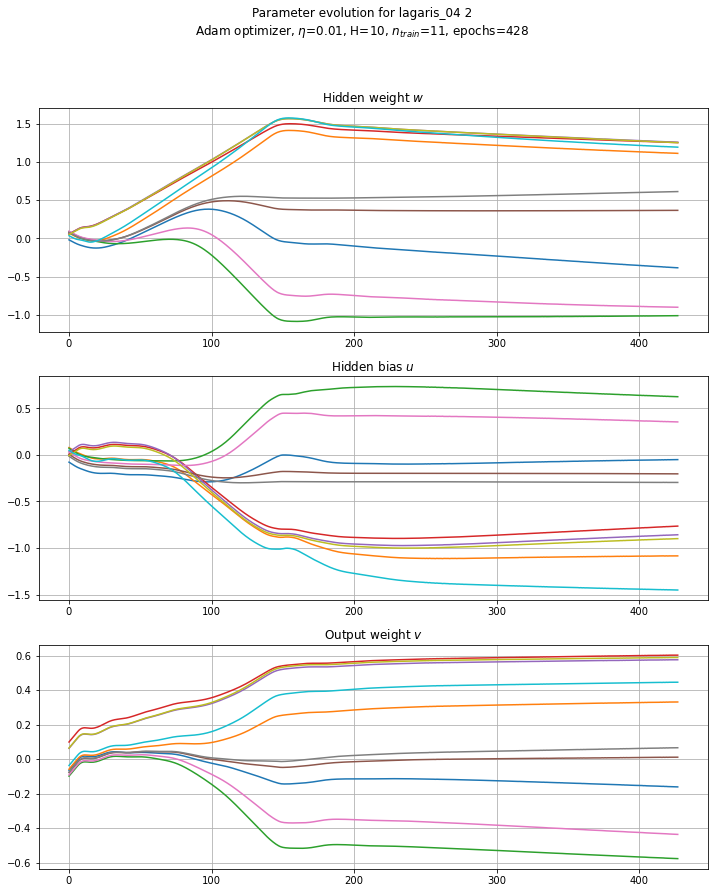

In [22]:
# Plot the parameter histories for model 2.
phist = np.array(phist2)
plt.figure(figsize=(12, 14))

# w
plt.subplot(311)
plt.plot(phist[:, 0:H])
plt.title("Hidden weight $w$")
plt.grid()

# u
plt.subplot(312)
plt.plot(phist[:, H:2*H])
plt.title("Hidden bias $u$")
plt.grid()

# v
plt.subplot(313)
plt.plot(phist[:, 2*H:3*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution for %s\n%s optimizer, $\eta$=%s, H=%s, $n_{train}$=%s, epochs=%s" %
          (eq_name + " 2", optimizer_name, learning_rate, H, n_train, epoch + 1))
plt.subplots_adjust(hspace=0.2)
plt.show()